### General rules:
 * For all figures that you generate, remember to add meaningful labels to the axes (including units), and provide a legend and colorbar, if applicable.
 * Do not hard code constants, like number of samples, number of channels, etc in your program. These values should always be determined from the given data. This way, you can easily use the code to analyse other data sets.
 * Do not use high-level functions from toolboxes like scikit-learn.
 * Before submitting, check your code by executing: Kernel -> Restart & run all.
 * Replace *Template* by your *FirstnameLastname* in the filename, or by *Lastname1Lastname2* if you work in pairs.

***
# BCI-IL WS 2018/2019 - Exercise Sheet #01
***

#### Name:

This exercise sheet refers to lecture \#2. The dataset is taken from an ERP Speller experiment, similar to the one discussed in the lecture. The first two tasks are about basic visualizations of Event-Related Potentials (ERPs), and the third one is the implementation of a univariate measure of separability and its visualization.

In [2]:
% matplotlib inline

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt

import bci_minitoolbox as bci

## Preparation: Loading Data

In [3]:
fname = 'erp_hexVPsag.npz'
cnt, fs, clab, mnt, mrk_pos, mrk_class, mrk_className = bci.load_data(fname)

## Exercise 1: Plotting ERPs  (5 points)

Plot the average ERPs corresponding to *target* and *nontarget* stimuli in the time interval -100 to 1000 ms for the channels Cz and PO7. This means that the average ERPs are class and channel-wise. <br>
In order to make the curves look reasonable, a so called 'baseline correction' should be performed: for each channel and trial, calculate the average across the prestimulus time interval -100 to 0 ms. This results in one value per channel and trial. Subtract this 'baseline' value from each (single channel/single trial) time course. 
The function `baseline` is provided in the `bci_minitoolbox`.
<font color=red>**It is recommended**</font> to have a look at the code of `bci.baseline`! It is three lines only, and shows, e.g., how to get the indices within an epoch that correspond to a given time interval. This will prove useful in future exercises.

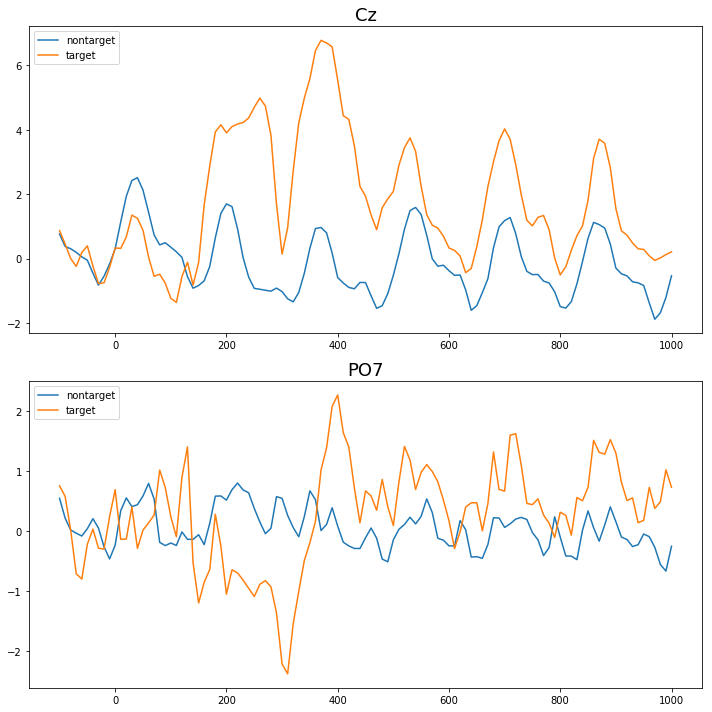

In [69]:
# Store given information in variables. Subsequent code should only refer to these variables and not
# contain the constants.
ival= [-100, 1000]
ref_ival= [-100, 0]
chans = ['Cz', 'PO7']

# Segment continuous data into epochs:
epo, epo_t = bci.makeepochs(cnt, fs, mrk_pos, ival)
# Baseline correction:
epo = bci.baseline(epo, epo_t, ref_ival)

# Now it is your turn to continue ...
chan_1 = clab.index(chans[0])
chan_2 = clab.index(chans[1])

tt = list(map(lambda x:1-x, mrk_class))

avg1 = np.average(epo[:,chan_1, :], axis=1, weights = mrk_class)
avg2 = np.average(epo[:,chan_2,:], axis=1, weights = mrk_class)
avg3 = np.average(epo[:,chan_1,:], axis=1, weights = tt)
avg4 = np.average(epo[:,chan_2,:], axis=1, weights = tt)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

axes[0].set_title("Cz", size=18)
axes[0].plot(epo_t, avg1, label="nontarget")
axes[0].plot(epo_t, avg3, label="target")
axes[0].legend(loc=2)

axes[1].set_title("PO7", size=18)
axes[1].plot(epo_t, avg2, label="nontarget")
axes[1].plot(epo_t, avg4, label="target")
axes[1].legend(loc=2)

plt.tight_layout()
plt.show()

## Exercise 2: Scalp Topographies of ERPs  (5 points)

Calculate the average potential separately for the classes *target* and *non-target* in the following time intervals [ms]: [160 200], [230 260], [300 320], and [380 430]. (This involves averaging over all trials of the respective class and averaging over all sample points in the respective time interval.)
Visualize the result as scalp topographies using the function `bci.scalpmap`, i.e., 4 maps for each class. <br>
**Note:** In order to make the maps look reasonable, do a *baseline correction* as in the previous task. To make the maps comparable, use a common scale for the colorbar (see help of `scalpmap`).

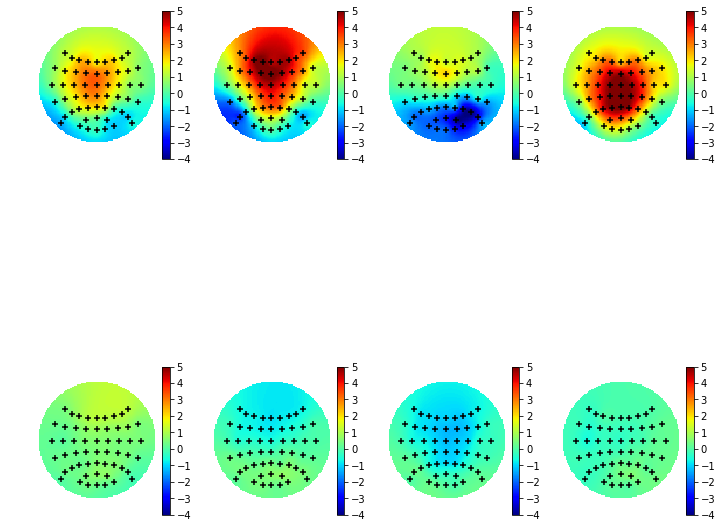

In [96]:
ival = [[160, 200], [230, 260], [300, 320], [380, 430]]

fig, axes = plt.subplots(2, 4, figsize=(12, 12))

epo, epo_t = bci.makeepochs(cnt, fs, mrk_pos, [-100, 1000])
idxref = (ref_ival[0] <= epo_t) & (epo_t <= ref_ival[1])
eporef = np.mean(epo[idxref, :, :], axis=0, keepdims=True)

for i in range(4):
    itv, itv_t = bci.makeepochs(cnt, fs, mrk_pos, ival[i])

    #Baseline correction
    itv = itv - eporef
    
    #nontarget
    tmp = np.average(itv, axis = 2, weights = mrk_class)
    tmp = tmp.transpose()
    v0 = np.average(tmp, axis = 1)
    
    plt.subplot(2, 4, i+5)
    bci.scalpmap(mnt, v0, clim = [-4, 5])
    
    #target
    tmp1 = np.average(itv, axis = 2, weights = tt)
    tmp1 = tmp1.transpose()
    v1 = np.average(tmp1, axis = 1)
    
    #plotted in the upper row 
    plt.subplot(2, 4, i+1)
    bci.scalpmap(mnt, v1, clim = [-4, 5])


## Exercise 3: Visualization with the Biserial Correlation Coefficient  (5 points)

Implement a function for the calculation of the signed `r^2`-value (see point-biserial correlation coefficient in BCI lecture \#02). From the given data set, extract epochs for the time interval [-100 600] ms relativ to each stimulus presentation.  Calculate for each channel and each point in time the signed `r^2`-value wrt. classes
*target* vs. *non-target* and visualize this (channel `x` time points) matrix (`pl.imshow`). Again, use 100 ms prestimulus for baseline correction.

In [181]:
def signed_r_square(epo, y):
    '''
    Synopsis:
        epo_r = signed_r_square(epo, y)
    Arguments:
        epo:    3D array of segmented signals (time x channels x epochs), 
                see makeepochs
        y:      labels with values 0 and 1 (1 x epochs)
    Output:
        epo_r:  2D array of signed r^2 values (time x channels)
    '''
    n0 = (y == 0).sum()
    n1 = (y == 1).sum()
    m1 = np.average(a = epo, axis = 2, weights=y)
    m0 = np.average(a = epo, axis = 2, weights= list(map(lambda x:1-x, y)))
    var = np.var(epo, axis=2)
    
    scalar = n0*n1*1.0 / (n0+n1)**2
    sign = (m0 - m1) / np.absolute(m0-m1)
    
    epo_r = sign * scalar * np.power((m0 - m1), 2) / var
    
    return epo_r

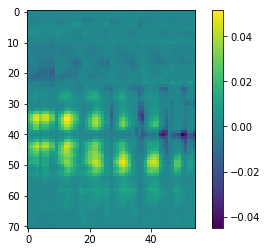

In [182]:
epof, epof_t = bci.makeepochs(cnt, fs, mrk_pos, [-100, 600])
# Baseline correction:
epof = bci.baseline(epof, epof_t, ref_ival)

result = signed_r_square(epof, mrk_class)
plt.imshow(result)
plt.colorbar()